-> Escolher classificador por omissão
-> Encontrar melhores parametros
-> Passar para as tarefas de classificação e avaliação


## <center>**Classificação de críticas de Cinema do IMDb**</center>

### **1- Introdução**

Este trabalho laboratorial será realizado com base nos dados textuais de críticas de cinema da IMDb (Internet Movie Database), uma base de dados composta por 50.000 textos de críticas e suas respetivas pontuações, recolhidas por Andrew Mass. As pontuações variam numa escala de 1 a 10, sendo que as críticas neutras (pontuações 5 e 6) foram excluídas.

O trabalho tem como objetivos principais:

1. Treinar e avaliar um classificador multi-classe para prever a pontuação das críticas.
2. Treinar e avaliar um regressor para prever a pontuação das críticas.
3. Realizar agrupamento (clustering) das críticas de forma não supervisionada.

Este relatório será organizado em três secções principais:

- **Introdução**: Apresentação do contexto e objetivos.
- **Desenvolvimento**: Descrição detalhada da metodologia aplicada, incluindo a construção do vocabulário, treino e avaliação dos modelos, e a análise dos métodos de clustering.
- **Conclusões e Análises**: Discussão dos resultados obtidos e considerações finais sobre o desempenho dos modelos e a relevância das técnicas aplicadas.

Import das bibliotecas necessárias na realização deste trabalho

In [72]:
# Importação de bibliotecas
import pickle
import re
import nltk
from nltk.stem import PorterStemmer
import numpy as np
from scipy.stats import randint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load dos dados e visualização de alguns exemplos

In [73]:
D = pickle.load(open('imdbFull.p', 'rb'))
X = D.data
y = D.target

print(f"Número de críticas: {len(X)}")
print(f"Exemplo de crítica: {X[0]}")
print(f"Exemplo de classificação: {y[0]}")

Número de críticas: 50000
Exemplo de crítica: Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty.
Exemplo de classificação: 10


### **2- Desenvolvimento**

A secção de desenvolvimento pode ser separada nos seguintes passos:
1. Limpeza do texto: Remoção de caracteres irrelevantes e normalização do texto;
- Equilibrar as várias classes
- Separar os dados em treino e teste (train_test_split)
- Usar o Tfidf nos dois conjuntos
2. Procura dos melhores parâmetros para o TfidfVectorizer;
3. Procura dos melhores parâmetros para cada modelo;
4. Treino e classificação dos modelos;
- Utilização do K-Folds
- Converçã dos valores contínuos do regressor para valores de classes
6. Clustering (KMeans, endogramas e svd): KMeans e svd funciona com sparse matrix 

#### **2.1 - Limpeza do texto**
Para o treino e análise dos modelos, é necessário realizar uma limpeza dos dados para remover símbolos e expressões desnecessárias, mas antes disso foi necessário realizar uma equilibração das classes visto que as classes `1` e `10` apresentavam cerca do dobro dos valores comparativamentes as outras classes.

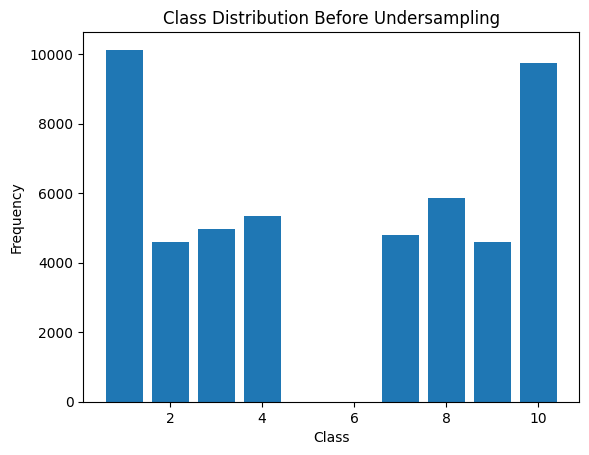

In [74]:
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)
plt.title("Class Distribution Before Undersampling")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

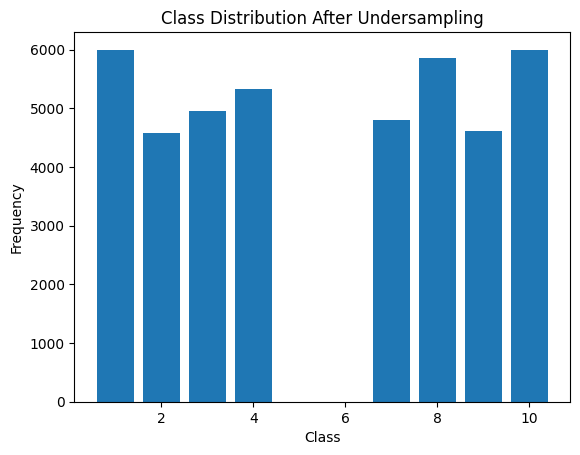

In [75]:
import pandas as pd

X = pd.DataFrame(X, columns=['text'])

undersampler = RandomUnderSampler(sampling_strategy={
    1: 6000,
    10: 6000
}, random_state=42)

X_resampled, y_resampled = undersampler.fit_resample(X, y)

unique_resampled, counts_resampled = np.unique(y_resampled, return_counts=True)
plt.bar(unique_resampled, counts_resampled)
plt.title("Class Distribution After Undersampling")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

X_resampled = np.array(X_resampled['text'])

In [76]:
print("Novo tamanho dos dados: ", len(X_resampled))

Novo tamanho dos dados:  42147


Depois de ser equilibrado o número de dados de cada classe pode-se então realizar a remoção de símbolos e expressões indejesadas, como por exemplo, a expressão que indica a mudança de linha (`<br />`) que é substituída por um espaço, são também removidos todos os caracteres não alfabéticos, preservando letras acentuadas e caracteres específicos de certas línguas, como `'ç'`.

In [77]:
# Limpar o texto
X_cleaned = [w.replace('<br />', ' ') for w in X_resampled]
X_cleaned = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', w) for w in X_resampled]

É realizado **stemming** com o objetivo de reduzir palavras às suas raízes ou formas básicas, removendo sufixos e prefixos, o que ajuda a simplificar o vocabulário dos dados, facilitando o processamento e a análise em tarefas de NLP (Processamento de Linguagem Natural).
Alguns benefícios de stemming são:

- **Redução da dimensionalidade**: Palavras derivadas (como "running" e "runner")  são reduzidas à mesma raiz ("run").

- **Generalização do Modelo**: Como são consideradas apenas as raízes das palavras, o modelo tende a aprender padrões mais gerais.

- **Simplificação do Vocabulário**: Ao simplificar o vocabolário pode ser aumentada a eficiência e acurácia do modelo.

In [78]:
# Stemming
try:
    X_stemmed = pickle.load(open('dados_stemmed.p', 'rb'))
except (FileNotFoundError, pickle.UnpicklingError) as e:
    print("Ficheiro não encontrado. Stemming...")
    stemmer = PorterStemmer()
    X_stemmed = [' '.join([stemmer.stem(w) for w in doc.split()]) for doc in X_cleaned]
    
    pickle.dump(X_stemmed, open('dados_stemmed.p', 'wb'))
    print("Arquivo criado e salvo com sucesso.")

In [79]:
print(X_stemmed[0])

model chri mccormack margaux hemingway is brutal rape by a teacher chri sarandon of her sister kathi mariel hemingway he is brought to trial but goe total free he then rape kathi br br objection and sick rape film thi movi wa advertis as an import drama deal with rape what it is is a badli written and for the most part badli act drama it purport to be sympathet to the victim of the rape but shove the scene in our face to be total honest howev hemingway s act is so bad in that sequenc that it lose ani real impact it might have had the trial scene were bore and predict and the movi just went too far when year old mariel is rape thank that wasn t shown i do admit though that it did lead to a great end when margaux grab a gun and shoot sarandon dead but serious have a young girl rape is just revolt br br act doesn t help for instanc margaux wa no actress she wa certainli a beauti woman and an actual model i believ but her act left a lot to be desir it lessen the film mariel wa just ok but 

Aqui é realizada uma separação dos dados de modo a ser possível treinar e testar os modelos quando se realiza a procura pelos melhores parâmetros. Esta separação poderia ser utilizada até ao final mas foi utilizado também o `K-Folds` de modo a aumentar a confiança nos resultados obtidos.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_stemmed, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

In [81]:
print("Tamanho do grupo de treino: ", len(X_train))
print("Tamanho do grupo de teste: ", len(X_test))

Tamanho do grupo de treino:  29502
Tamanho do grupo de teste:  12645


#### **2.2- Procura dos melhores parâmetros para o TfidfVectorizer**
A procura pelos melhores parâmetros para o `TfidfVectorizer` é realizada através de várias tentativas com diversas combinações de parâmetros devido ao tamanho dos dados o uso do `GridSearchCV` não foi viável. Foram definidos espaços de pesquisa, com base no `RandomForestClassifier`, foi escolhido este modelo pela sua simplicidade e robustez, não sendo afetado por altas dimensionalidades, o que o torna ideal para ajustes iniciais do vocabulário.

In [82]:
tfidf = TfidfVectorizer(
    min_df=5,
    token_pattern=r'\b\w\w\w+\b', 
    max_features=35000, 
    ngram_range=(1,2), 
    lowercase=True, 
    sublinear_tf=True,
    stop_words='english').fit(X_train)
tokens = tfidf.get_feature_names_out()
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)
print(len(tokens))

35000


Accuracy: 32.03


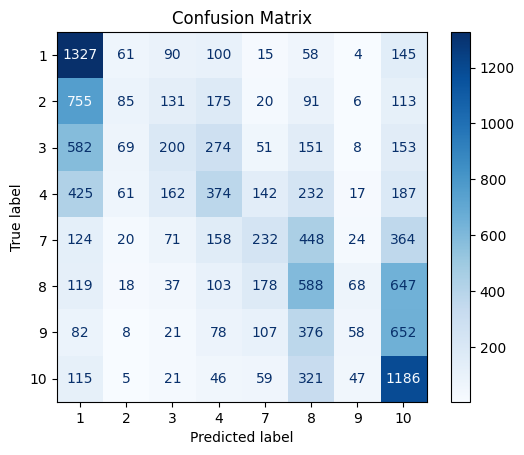

In [83]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy*100:.2f}")

cm = confusion_matrix(y_test, y_pred_rf)

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

#### **2.3- Procura dos melhores parâmetros para cada modelo**
Após otimizar os parâmetros do `TfidfVectorizer`, o próximo passo é ajustar os hiperparâmetros específicos de cada modelo para maximizar o seu desempenho. O ajuste é realizado através de várias tentativas para testar diferentes combinações de valores de hiperparâmetros, avaliando a acurácia e a matriz de confusão, estes podem não ser os melhores parâmetros globais mas devido a limitações computacionais não foi possível realizar uma busca mais profunda.

Nesta secção, exploraremos os modelos escolhidos:

- **Logistic Regression** para classificação.
- **Ridge Regression** para regressão.

Estes modelos foram escolhidos pelos resultados apresentados através de alguns testes iniciais com parâmetros simples, o que indica que estes podem não ser os melhores com as combinações ideais de parâmetros, mas nos testes realizados apresentaram os melhores resultados, sendo que na classificação tanto o **Logistic Regression** como o **SVC** obtiveram resultados similares, porém o **Logistic Regression** foi capaz de treinar e testar os dados exponencialmente mais rápido que o **SVC**, sendo assim este o modelo escolhido. Já na regressão o **Ridge** apresentou resultados substancialmente melhores que os outros modelos testados (**Lasso Regression** e **Linear Regression**).

#### 2.3.1- Parâmetros para o classificador
De modo a serem encontrados os melhores parâmetros "locais" para o classificador **Logistic Regression** foram testados vários valores para alguns parâmetros, sendo que se guardaram os melhores, como pode ser observado na seguinte tabela:


| Parâmetro        | Descrição                            | Valores                       | Melhor Valor |
|------------------|--------------------------------------|-------------------------------|--------------|
| **C**            | Inverso da força de regularização    | `1.5, 1.0, 0.5, 0.1`          | 0.5          |
| **max_iter**     | Número máximo de iterações           | `1000, 500, 300, 100`         | 300          |
| **penalty**      | Muda o tipo de penalidade adicionada | `l2, l1, elasticnet, None`    | l2           |
| **solver**       | O tipo de algoritmo utilizado        | `saga, lbfgs, newton-cg, sag` | lbfgs        |
| **class_weight** | Peso associado a cada classe         | `balanced, None`              | None         |

Esta combinação apresenta os melhores resultados, foi observado que este valor de iterações foi suficiente visto que, com um valor maior os resultados são os mesmo, o que indica que o modelo converge em 300 ou menos iterações.

Accuracy: 37.60


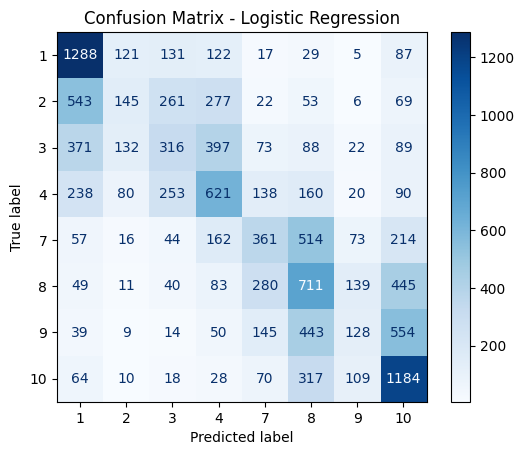

In [84]:
# Treinar o modelo Logistic Regression
lr = LogisticRegression(penalty='l2', C=0.5, max_iter=300, solver='lbfgs', random_state=42)
lr.fit(X_train, y_train)

# Fazer previsões
y_pred_lr = lr.predict(X_test)

# Calcular acurácia
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy*100:.2f}")

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_lr)

# Exibir a matriz de confusão
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

#### 2.3.2- Parâmetros para o regressor
Antes de serem testados os parâmetros foram testados alguns modelos, e o modelo `Ridge` apresentou os melhores resultados base, o que não impede de outros modelos apresentarem melhores resultados com outras combinações não testadas, mas divido a recursos limitados, tomou-se este modelo como escolhido.

Na procura dos melhores parâmetros locais foi preciso fazer uma procura da melhor combinação, para tal foi necessário testar vários parâmetros obtendo os seguintes resultados:

| Parâmetro  | Descrição                      | Valores                   | Melhor Valor |
|------------|--------------------------------|---------------------------|--------------|
| **alpha**  | Força de regularização.        | `0.5, 0.7, 1.0, 1.2, 1.5` | 1.2          |
| **tol**    | Precisão da solução (`coef_`). | `1e-4, 1e-3, 1e-2`        | 1e-4         |
| **solver** | O tipo de algoritmo utilizado. | `auto, lsqr, sag`         | auto         |

Durantes os vários testes reparou-se que tirando os parâmetros `alpha` e `solver` os outros não apresentavam diferenças relevantes na regressão.

In [85]:
# Treinar o modelo Ridge Regression
ridge = Ridge(alpha=1.2, max_iter=1000, solver='auto', tol=1e-4, random_state=42)
ridge.fit(X_train, y_train)

# Fazer previsões
y_pred_ridge = ridge.predict(X_test)

# Calcular métricas
mse = mean_squared_error(y_test, y_pred_ridge)
r2 = r2_score(y_test, y_pred_ridge)
print(f"Ridge Regression - MSE: {mse:.2f}, R2: {r2:.2f}")

Ridge Regression - MSE: 4.08, R2: 0.61


#### **2.4- Treino e avaliação dos modelos**
O treino e avaliação dos modelos são etapas essenciais para verificar a capacidade preditiva e a generalização dos algoritmos. Neste trabalho, foi utilizado um classificador (Logistic Regression) e um regressor (Ridge Regression) para prever as notas das críticas de cinema.
Nesta secção foi realizada também uma separação dos dados através do K-Folds visto que este apresenta as seguintes vantagens:
- **Estimativas mais confiáveis**: O K-Folds reduz o viés de uma única divisão dos dados, fornecendo uma avaliação mais robusta do desempenho do modelo.
- **Divisão equilibrada**: Com 50.000 críticas distribuídas em diferentes classes (1-4 e 7-10), o K-Folds garante que todas as classes sejam representadas tanto no treino quanto no teste.
- **Generalização**: Como cada exemplo é utilizado como teste em algum momento, o método avalia a capacidade do modelo de generalizar para dados não vistos.

Isto permite assim adicionar outra camada de confiança sobre os resultados obtidos anteriormente.

In [86]:
tfidf = TfidfVectorizer(
    min_df=5,
    token_pattern=r'\b\w\w\w+\b', 
    max_features=35000, 
    ngram_range=(1,2), 
    lowercase=True, 
    sublinear_tf=True,
    stop_words='english').fit(X_stemmed)
tokens = tfidf.get_feature_names_out()
X_tfidf = tfidf.transform(X_stemmed)

**Treino e Avaliação com Classificadores**

Para os classificadores, os dados foram divididos num conjuntos de treino e teste utilizando a técnica de validação cruzada (K-Folds). Esta metodologia garante que todos os dados sejam utilizados para treino e teste pelo menos uma vez, reduzindo vieses e garantindo maior confiabilidade nos resultados. A métrica principal utilizada para avaliar os classificadores foi a `accuracy`, complementada com a matriz de confusão e o relatório de classificação (precision, recall e F1-score).

Resultado por fold: [37.74614472123369, 37.74614472123369, 36.88456519160043, 36.55237869260885, 37.631984814331474]
Acurácia média: 37.31
Melhor fold: 1 com acurácia: 37.75


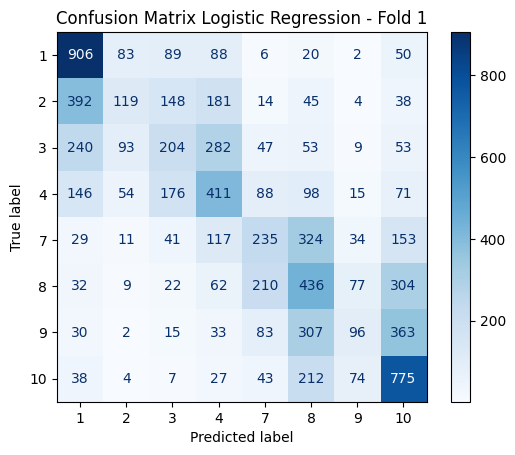


Classification Report Logistic Regression - Fold 1:

              precision    recall  f1-score   support

           1       0.50      0.73      0.59      1244
           2       0.32      0.13      0.18       941
           3       0.29      0.21      0.24       981
           4       0.34      0.39      0.36      1059
           7       0.32      0.25      0.28       944
           8       0.29      0.38      0.33      1152
           9       0.31      0.10      0.15       929
          10       0.43      0.66      0.52      1180

    accuracy                           0.38      8430
   macro avg       0.35      0.35      0.33      8430
weighted avg       0.36      0.38      0.35      8430



In [87]:
# Configuração do K-Folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression(penalty='l2', C=0.5, max_iter=300, solver='lbfgs', random_state=42)

accuracies = []
best_fold = None
best_accuracy = 0
best_results = {}

for fold_idx, (train_index, test_index) in enumerate(kf.split(X_tfidf), 1):
    # Separar os dados de treino e teste
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Avaliar o modelo
    y_pred_lr = model.predict(X_test)

    # Calcular a métrica
    accuracy = accuracy_score(y_test, y_pred_lr) * 100
    accuracies.append(accuracy)

    # Salvar os resultados do melhor fold
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = fold_idx
        best_results = {
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test,
            "y_pred": y_pred_lr,
        }

# Exibir resultados
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Resultado por fold: {accuracies}")
print(f"Acurácia média: {mean_accuracy:.2f}")
print(f"Melhor fold: {best_fold} com acurácia: {best_accuracy:.2f}")

# Detalhes do melhor fold
y_test = best_results["y_test"]
y_pred_lr = best_results["y_pred"]

# Matriz de Confusão
cm_lr = confusion_matrix(y_test, y_pred_lr)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=np.unique(y_test))
cmd.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix Logistic Regression - Fold {best_fold}")
plt.show()

# Classification Report
print(f"\nClassification Report Logistic Regression - Fold {best_fold}:\n")
print(classification_report(y_test, y_pred_lr, target_names=[str(cls) for cls in np.unique(y_test)]))


**Treino e Avaliação com Regressores**

Para os regressores, o objetivo foi prever as notas como valores contínuos. Posteriormente, as previsões foram convertidas para classes utilizando intervalos predefinidos. As métricas principais utilizadas foram o `Mean Squared Error (MSE)` e o `R²`, sendo que os resultados de classificação foram avaliados com base na matriz de confusão e no relatório de classificação, similar aos classificadores.

Resultado por fold (MSE): [np.float64(4.037792574150089), np.float64(4.025599027105693), np.float64(3.993505176816135), np.float64(3.934724992793872), np.float64(3.953422531929241)]
MSE médio: 3.9890, Desvio padrão: 0.0399
R² médio: 0.6230
Melhor fold: 4 com MSE: 3.9347
Accuracy: 27.49


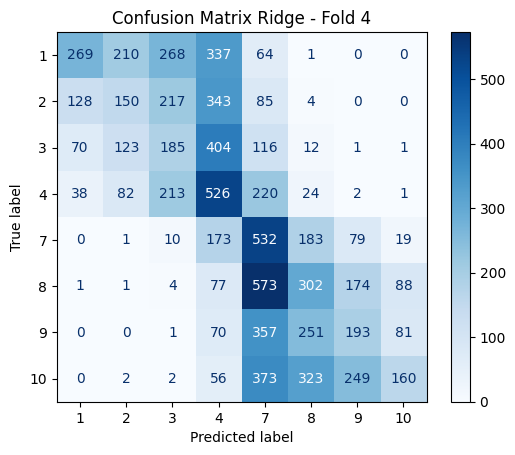


Classification Report Ridge - Fold 4:

              precision    recall  f1-score   support

           1       0.53      0.23      0.33      1149
           2       0.26      0.16      0.20       927
           3       0.21      0.20      0.20       912
           4       0.26      0.48      0.34      1106
           7       0.23      0.53      0.32       997
           8       0.27      0.25      0.26      1220
           9       0.28      0.20      0.23       953
          10       0.46      0.14      0.21      1165

    accuracy                           0.27      8429
   macro avg       0.31      0.27      0.26      8429
weighted avg       0.32      0.27      0.26      8429



In [88]:
# Configuração do K-Folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

model = Ridge(alpha=1.2, max_iter=1000, solver='auto', tol=1e-4, random_state=42)

mse_scores = []
r2_scores = []
best_fold = None
best_mse = float("inf")
best_results = {}

# Definição dos bins e classes
bins = [1.5, 2.5, 3.5, 5.5, 7.5, 8.5, 9.5]
classes = [1, 2, 3, 4, 7, 8, 9, 10]

for fold_idx, (train_index, test_index) in enumerate(kf.split(X_tfidf), 1):
    # Separar os dados de treino e teste
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Fazer previsões contínuas
    y_pred_ridge = model.predict(X_test)

    # Calcular métricas de regressão
    mse = mean_squared_error(y_test, y_pred_ridge)
    r2 = r2_score(y_test, y_pred_ridge)
    mse_scores.append(mse)
    r2_scores.append(r2)

    # Converter previsões contínuas para classes
    y_pred_class = []
    for pred in y_pred_ridge:
        if pred < bins[0]:
            y_pred_class.append(classes[0])  # Classe 1
        elif pred < bins[1]:
            y_pred_class.append(classes[1])  # Classe 2
        elif pred < bins[2]:
            y_pred_class.append(classes[2])  # Classe 3
        elif pred < bins[3]:
            y_pred_class.append(classes[3])  # Classe 4
        elif pred < bins[4]:
            y_pred_class.append(classes[4])  # Classe 7
        elif pred < bins[5]:
            y_pred_class.append(classes[5])  # Classe 8
        elif pred < bins[6]:
            y_pred_class.append(classes[6])  # Classe 9
        else:
            y_pred_class.append(classes[7])  # Classe 10

    y_pred_class = np.array(y_pred_class)

    # Salvar os resultados do melhor fold (com menor MSE)
    if mse < best_mse:
        best_mse = mse
        best_fold = fold_idx
        best_results = {
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test,
            "y_pred": y_pred_class,
            "y_pred_continuous": y_pred_ridge,
        }

# Exibir resultados
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Resultado por fold (MSE): {mse_scores}")
print(f"MSE médio: {mean_mse:.4f}, Desvio padrão: {std_mse:.4f}")
print(f"R² médio: {mean_r2:.4f}")
print(f"Melhor fold: {best_fold} com MSE: {best_mse:.4f}")


# Detalhes do melhor fold
y_test = best_results["y_test"]
y_pred_class = best_results["y_pred"]
y_pred_continuous = best_results["y_pred_continuous"]

accuracy = accuracy_score(y_test, y_pred_class) * 100
print(f"Accuracy: {accuracy:.2f}")

# Matriz de Confusão
cm_ridge = confusion_matrix(y_test, y_pred_class)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm_ridge, display_labels=classes)
cmd.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix Ridge - Fold {best_fold}")
plt.show()

# Classification Report
print(f"\nClassification Report Ridge - Fold {best_fold}:\n")
print(classification_report(y_test, y_pred_class, target_names=[str(cls) for cls in classes]))

### 2.5- Clustering

O clustering foi utilizado como abordagem não supervisionada para agrupar críticas de cinema com base nas características extraídas pelo TF-IDF. O algoritmo principal escolhido foi o `K-Means` . Adicionalmente, outros algoritmos, como DBSCAN e GMM, foram ponderados como alternativas para lidar com clusters de forma arbitrária ou com dados ruidosos, mas no final escolheu-se o `K-Means`visto que é um método simples e rápido de treinar, mas mantendo a sua robustez.

#### Escolha do Número de Clusters

Para determinar o número ideal de clusters, foi aplicado o Elbow Method e calculado o Silhouette Score para os vários números de clusters e parâmetros do `K-Means` e do `PCA`. Estes métodos permitiram avaliar a coesão interna e a separação entre clusters, depois da análise do gráfico obtido decidiu-se que 4 clusters seriam adequados para este conjunto de dados.

#### Resultados do Clustering

Os clusters foram visualizados através de uma redução de dimensionalidade com **PCA**, permitindo observar padrões e relações entre os dados agrupados.

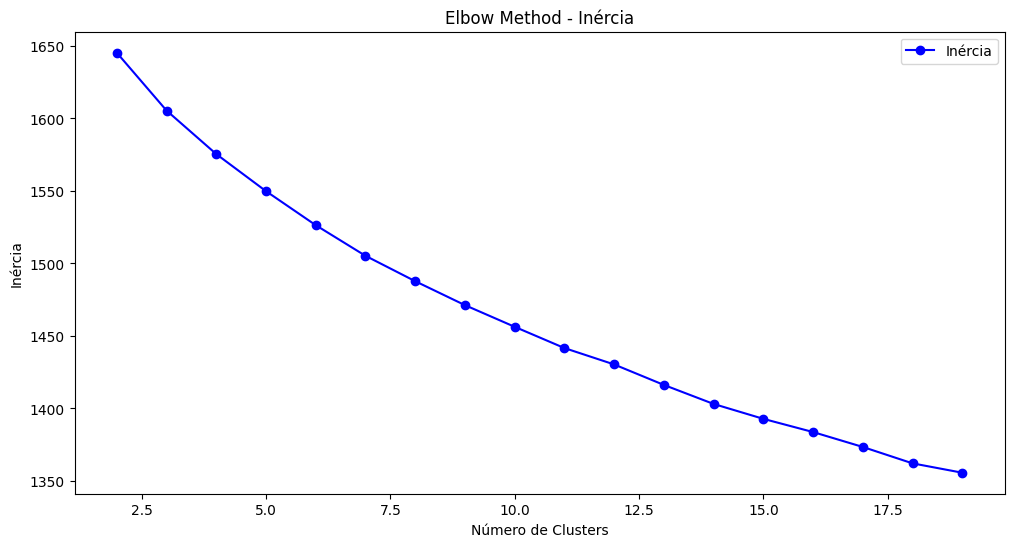

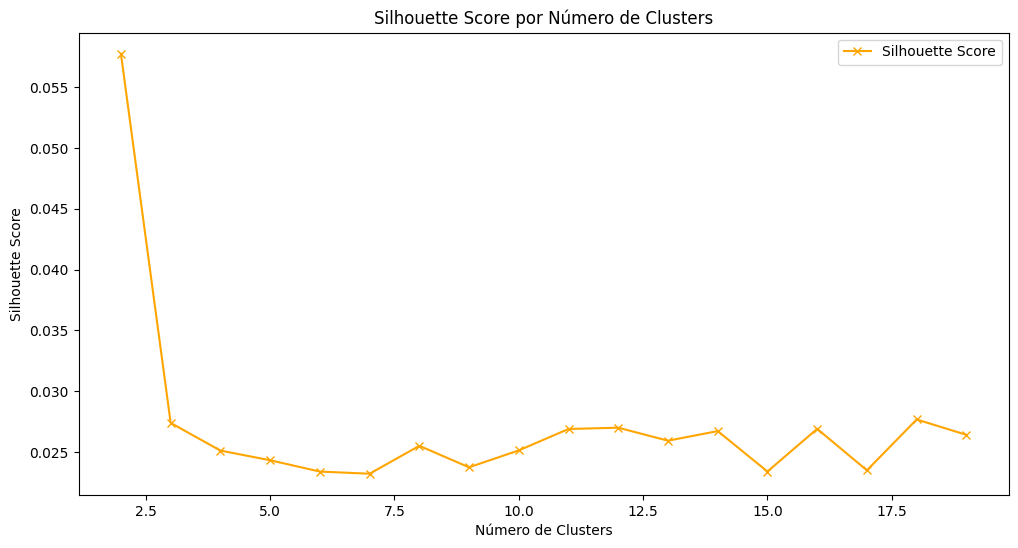

In [97]:
# Determinar o número ideal de clusters (Elbow Method)
inertia = []
silhouette_scores = []
range_clusters = range(2, 10)
pca = PCA(n_components=2, random_state=42)
X_tfidf_reduced = pca.fit_transform(X_tfidf.toarray())

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    kmeans.fit(X_tfidf_reduced)
    inertia.append(kmeans.inertia_)  # Soma das distâncias quadráticas
    silhouette_scores.append(silhouette_score(X_tfidf_reduced, kmeans.labels_))

plt.figure(figsize=(12, 6))
plt.plot(range_clusters, inertia, marker='o', color="blue", label="Inércia")
plt.title("Elbow Method - Inércia")
plt.xlabel("Número de Clusters")
plt.ylabel("Inércia")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range_clusters, silhouette_scores, marker='x', color="orange", label="Silhouette Score")
plt.title("Silhouette Score por Número de Clusters")
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

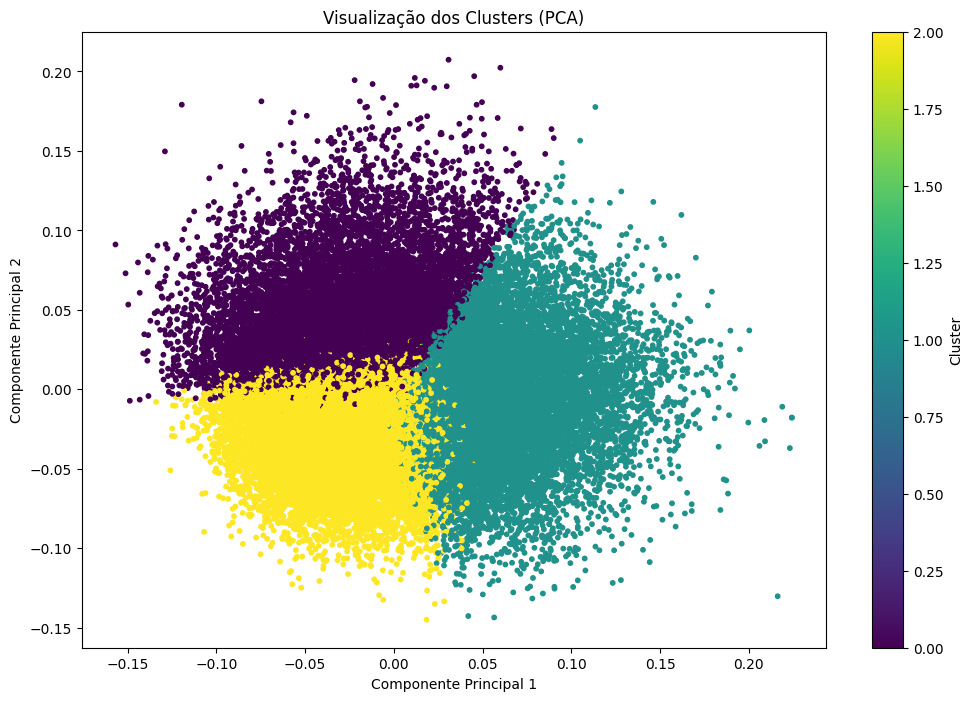

Centroides dos Clusters:
[[2.97696961e-05 2.75938005e-05 2.12109501e-05 ... 3.52903410e-05
  1.88520031e-04 1.06332510e-04]
 [1.01325693e-04 1.18840229e-04 9.19085387e-05 ... 1.32785164e-05
  1.87874091e-05 1.19415391e-04]
 [2.88761244e-05 1.03617704e-04 5.63904285e-05 ... 2.25893330e-04
  1.42877953e-04 8.01356564e-05]]
Labels dos Clusters (primeiros 10 elementos):
[0 2 1 0 1 1 1 1 1 2]


In [104]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=50)
kmeans.fit(X_tfidf)

# Redução de dimensionalidade para visualização (com PCA)
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_tfidf.toarray())

# Plot dos Clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans.labels_, cmap='viridis', s=10)
plt.title("Visualização dos Clusters (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")
plt.show()

# Analisando os Clusters
print(f"Centroides dos Clusters:\n{kmeans.cluster_centers_}")
print(f"Labels dos Clusters (primeiros 10 elementos):\n{kmeans.labels_[:10]}")

### **3- Conclusões e Análises**
Neste trabalho foi possível observar as capacidades de vários modelos na classificação de críticas de filmes, foram testadas vários modelos tanto de classificação como de regressão, sendo que se acabou por se focar em apenas um modelo de classificação e um de regressão, sendo estes o **Logistic Regression** e o **Ridge**, respetivamente. 

Antes de se começar o processo de treino e classificação de texto é necessário a realização de algumas técnicas, das várias técnicas existentes foram utilizadas algumas como a limpeza do texto, que incluíu a remoção de símbolos e expressões indesejadas (`</br />`) mas mantendo caracteres especiais e acentuados, sendo que nestes dados só temos críticas em inglês que não utilizam esses caracteres, seguindo a limpeza do texto foi também realizado o `stemming` das várias palavras, permitindo só utilizar a raiz das palavras que diminuí a dimensionalidade dos dados, existem várias técnicas de `stemming` como o Snowball, Lancaster, mas neste trabalho optou-se pelo Porter sendo que é um dos mais utilizados e estudados. É importante referir que para este conjuntos de dados em específico foi também necessário equilibrar o número de amostras de cada classe visto que as classes **1** e **10** tinham cerca do dobro do número de amostras comparativamente ás outras classes.

In [99]:
# Non-stemmed
print(f"Texto limpo: {X_cleaned[0][:10]}")

# Stemmed
print(f"Texto 'stemmed': {X_stemmed[0][:10]}")

Texto limpo: Model Chri
Texto 'stemmed': model chri


O último passo de preparação dos dados aplicado foi a utilização do `TfidfVectorizer` que permite criar **tokens** apartir dos dados e organiza-los por importância (palavras que apareçam muitas vezes em poucos documentos podem ser bons indicadores de contexto, comparativamente a palavras que aparecem em muitos documentos). Este método apresenta vários parâmetros que podem ser alterados para mudar os resultados que se obtém, alguns desses parâmetros são o número máximo de tokens, número mínimo de vezes que uma palavra tem que aparecer para ser considerada ou até a aplicação de **expressões regulares** para só se aceitar certos tipos ou comprimentos de palavras, de tal modo foi necessário realizar vários testes com diversos parâmetros para se encontrar uma boa combinação, para testar se eram bons parâmetros foi utilizado o **RandomForest** com os seus parâmetros por ommissão, visto que este é um modelo robusto e simples, deste modo, pareceu a escolha indicada para uma configuração inicial do `TfidfVectorizer`.

In [100]:
# Alguns tokens
print(f"Alguns tokens: {tokens[:10]}")

Alguns tokens: ['aaliyah' 'aamir' 'aamir khan' 'aardman' 'aaron' 'aaron eckhart' 'aback'
 'abandon' 'abba' 'abbey']


Após a preparação dos dados foi necessário a preparação dos modelos, ou seja, encontrar os melhores parâmetros para os dados de modo a se ter os melhores resultados, existem vários métodos que são utilizados como o **GridSearchCV** ou o **RandomSearch** mas devido ao elevado número de dados e limitações computacionais não foi possível a utilização desses métodos, em alternativa foram testadas várias combinações manualmente e guardado a melhor combinação de parâmetros encontrada. Este processo foi realizado numa fase inicial em vários modelos, tendo sido escolhido um classificador e um regressor desses vários modelos, onde então foram testados mais combinações de parâmetros.

No treino e teste foram obtidas diversas métricas que vão ser analisadas de seguida, entre estas temos **accuracy**, **precision**, **recall**, **f1-score**  e a **Matriz de connfusão** para o classificador (**Logistic Regression**), já para o regressor utilizou-se o **MSE** (Erro quadrático médio) e o **R²** (Coeficiente de determinação). Os resultados obtidos no regressor são números contínuos e de modo a serem comparados ao classificador, estes foram convertidos para os valores das várias classes através de intervalos de seleção, depois de realizada a conversão foi possível analisar as mesmas métricas utilizadas para o classificador.

Numa análise geral pode-se observar que o classificador obteu uma taxa de acertos maior que o regressor:

In [93]:
print(f'Número de acertos por classe no classificador: {np.diag(cm_lr)}')

Número de acertos por classe no classificador: [906 119 204 411 235 436  96 775]


Já numa análise das `matrizes de confusão` de ambos os modelos é possível observar que as classes que apresentavam mais valores foram também as com maior número de acertos, o que indica que seria um indicador de que se os dados tivessem todos os mesmos números seria possível obter melhores resultados, porém depois de se testar isso observou-se que o número de acertos nas outras classes não aumentou, apenas reduziu nas classes que antes tinham mais amostras anteriormente, isto propõe a idea de que seria talvez preciso de mais dados para todas as classes para se obter melhores resultados.

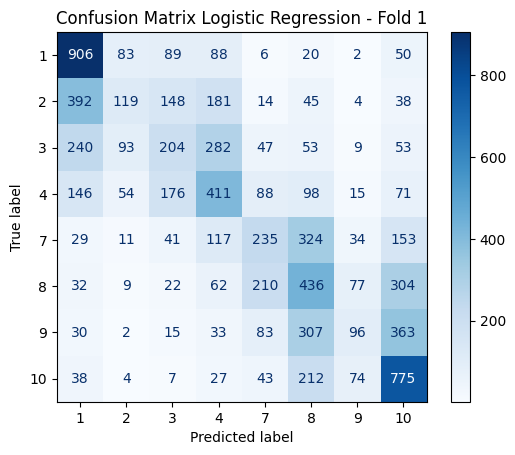
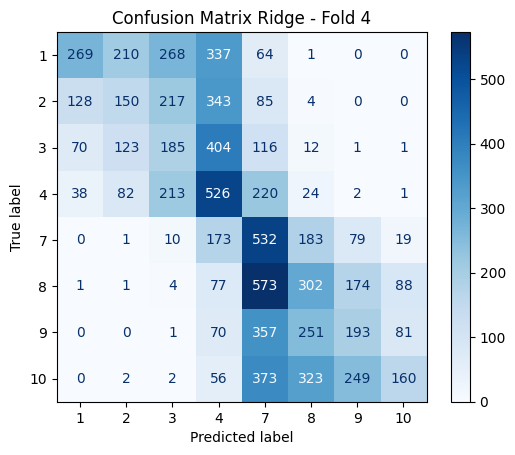


Também se utilizou o método `classification_report` para obter várias métricas para os modelos, onde novamento o classificador apresentou melhores resultados.

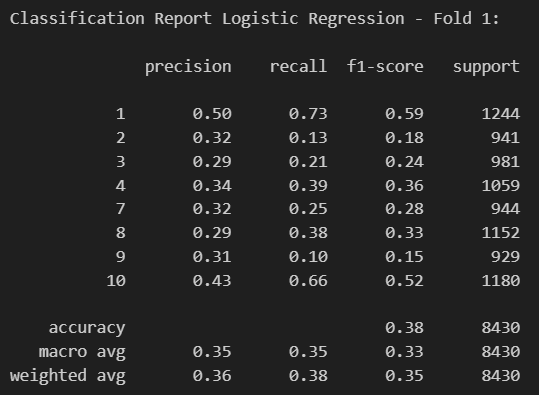
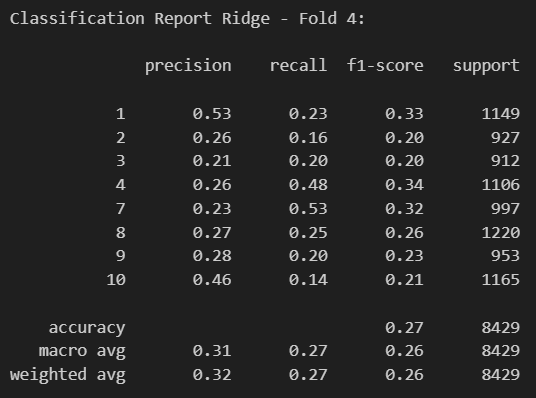


Depois do treino e classificação dos modelos foi testados que resultados se iriam obter através de um método não supervisionado, neste trabalho o método testado foi `Clustering` através do algoritmo `K-Means`, foram testados outros como o `DBSCAN e GMM` mas estes não apresentaram resultados substancialmente melhores mas foram mais computacionalmente intensivos. Os resultados obtidos nos gráficos do **Elbow Method** e **Silhouette Score** mostram que com apenas 2 clusters temos umas melhor separação dos dados mas os dados também se encontram longe do seu centróide, mas quando se começa a aumentar o número de clusters perde-se grande parte da separação entre os clusters, sendo assim entre 2 a 4 clusters seria os resultados mais otimistas, sendo que existe sempre alguma sobreposição nas separações dos clusters.

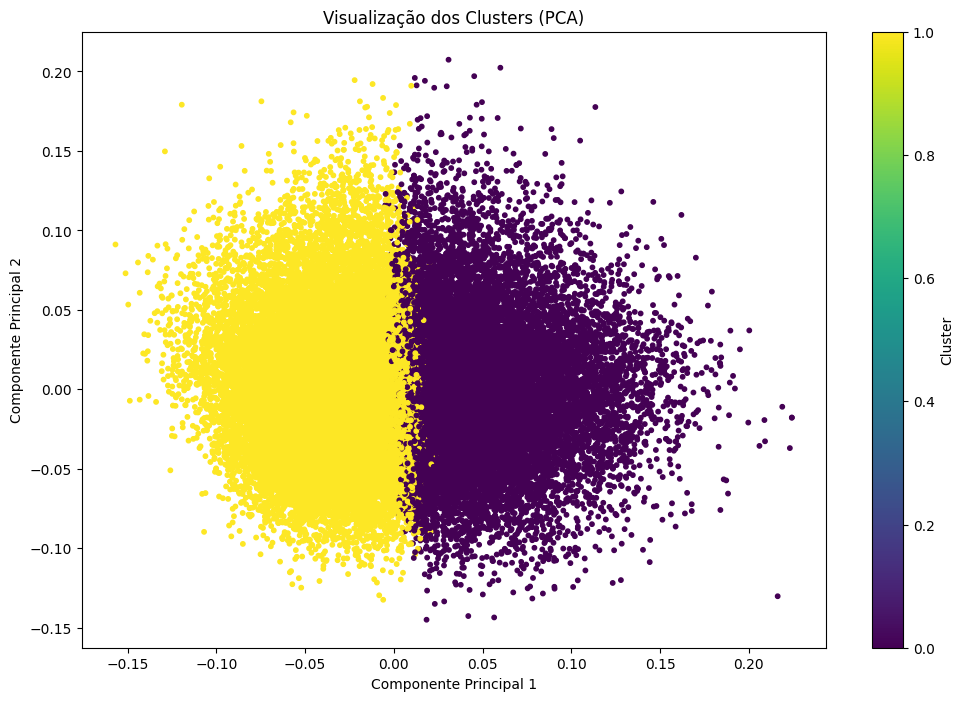